In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from collections import Counter
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

from imblearn.over_sampling import RandomOverSampler

In [2]:
feature_list = torch.load(f"./NSCLC_features.pt")
subjects = torch.load(f"./NSCLC_subjects.pt")
labels = torch.load(f"./NSCLC_labels.pt")

# label1 = [histology.split("/")[-1].split("_")[-1].split(".")[0] for histology in glob("../../data/NSCLC-Interobserver/volume+seg/*label*")]
# label2 = [histology.split("/")[-1].split("_")[-1].split(".")[0] for histology in glob("../../data/NSCLC-Radiogenomics//volume+seg/*label*")]
# label3 = [histology.split("/")[-1].split("_")[-1].split(".")[0] for histology in glob("../../data/NSCLC-Radiomics//volume+seg/*label*")]
# labels = label1 + label2 + label3

keys = [key for key in feature_list[0].keys() if key.startswith("original")]
keys.extend([key for key in feature_list[0].keys() if key.startswith("wavelet")])
print(f"Num of features: {len(keys)}")
data = {}
   
for i in tqdm(range(len(feature_list))):
    features = feature_list[i]

    data_features = {}
    for feature_name in keys:
        data_features[feature_name] = features[feature_name].item()
        data[i] = data_features

df = pd.DataFrame(data).transpose()
df["subject"] = subjects
df["label"] = labels
# df = df[(df["histology"].str.contains("adeno")) | (df["histology"].str.contains("squamous"))]
# df["label"] = [0 if "adeno" in histology else 1 for histology in df.histology]
# df.histology.value_counts()
df

Num of features: 806


100%|██████████| 359/359 [00:00<00:00, 6486.88it/s]


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,subject,label
0,0.885270,0.756312,70.070657,92.647866,116.180893,101.833197,104.043260,125.211821,360353.250000,82.018346,...,11008.050826,84.057889,1.063655e+06,0.009364,0.000288,0.172215,1229.652336,0.000087,LUNG1-002,1
1,0.497379,0.288597,30.815927,106.778393,111.682586,110.145359,69.115845,117.426573,84630.250000,53.109285,...,11299.726709,41.661075,5.300174e+05,0.003574,0.000151,0.244187,2202.802911,0.000065,LUNG1-004,1
2,0.715464,0.449774,35.202882,78.267958,77.620873,87.618491,85.146932,104.522725,82165.125000,55.997883,...,13434.281934,44.774434,6.589335e+05,0.003187,0.000123,0.226642,2413.412723,0.000056,LUNG1-005,1
3,0.958011,0.626994,38.387009,61.223892,73.389373,76.157731,70.837843,76.321688,77322.333333,58.653188,...,10497.056959,18.522895,2.759212e+05,0.002806,0.000418,0.436241,3365.845007,0.000232,LUNG1-006,1
4,0.906912,0.845611,24.562913,29.047541,36.124784,35.902646,34.928498,37.229021,11992.458333,26.343556,...,7177.418931,29.643065,2.767529e+05,0.003467,0.000314,0.404207,2159.272793,0.000226,LUNG1-007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.863116,0.755852,33.431605,44.230354,47.010637,57.723479,54.083269,59.000000,36098.791667,38.175915,...,7332.459630,50.318397,4.570096e+05,0.005806,0.000232,0.271995,1470.471223,0.000114,interobs29,0
355,0.583503,0.405122,25.852102,63.813195,48.548944,73.006849,63.600314,76.615925,36242.958333,37.235189,...,6864.506389,50.514320,4.538322e+05,0.006313,0.000356,0.294491,1397.440241,0.000197,interobs31,1
356,0.744816,0.615395,43.292611,70.349292,90.603532,78.000000,62.968246,91.564185,104918.666667,52.397289,...,10902.238102,68.643209,8.600805e+05,0.005919,0.000169,0.222640,1786.964830,0.000058,interobs32,0
357,0.678212,0.560962,15.298616,27.272089,32.557641,27.294688,25.019992,32.802439,4680.041667,18.496246,...,3613.684088,5.922881,3.262604e+04,0.005082,0.001401,0.536464,1647.511846,0.000922,interobs33,0


In [3]:
values = df.to_numpy()
X = values[:, :-2]
y = values[:, -1]
y = y.astype(int)

### Feature Selection: LASSO

215
72
72


/home/johannes/anaconda3/envs/viewGCN/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.596e-01, tolerance: 4.272e-03
  model = cd_fast.enet_coordinate_descent(
/home/johannes/anaconda3/envs/viewGCN/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.959e-01, tolerance: 4.272e-03
  model = cd_fast.enet_coordinate_descent(
/home/johannes/anaconda3/envs/viewGCN/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Best Alpha: 0.03610000000000001
Num remaining feaures: 18


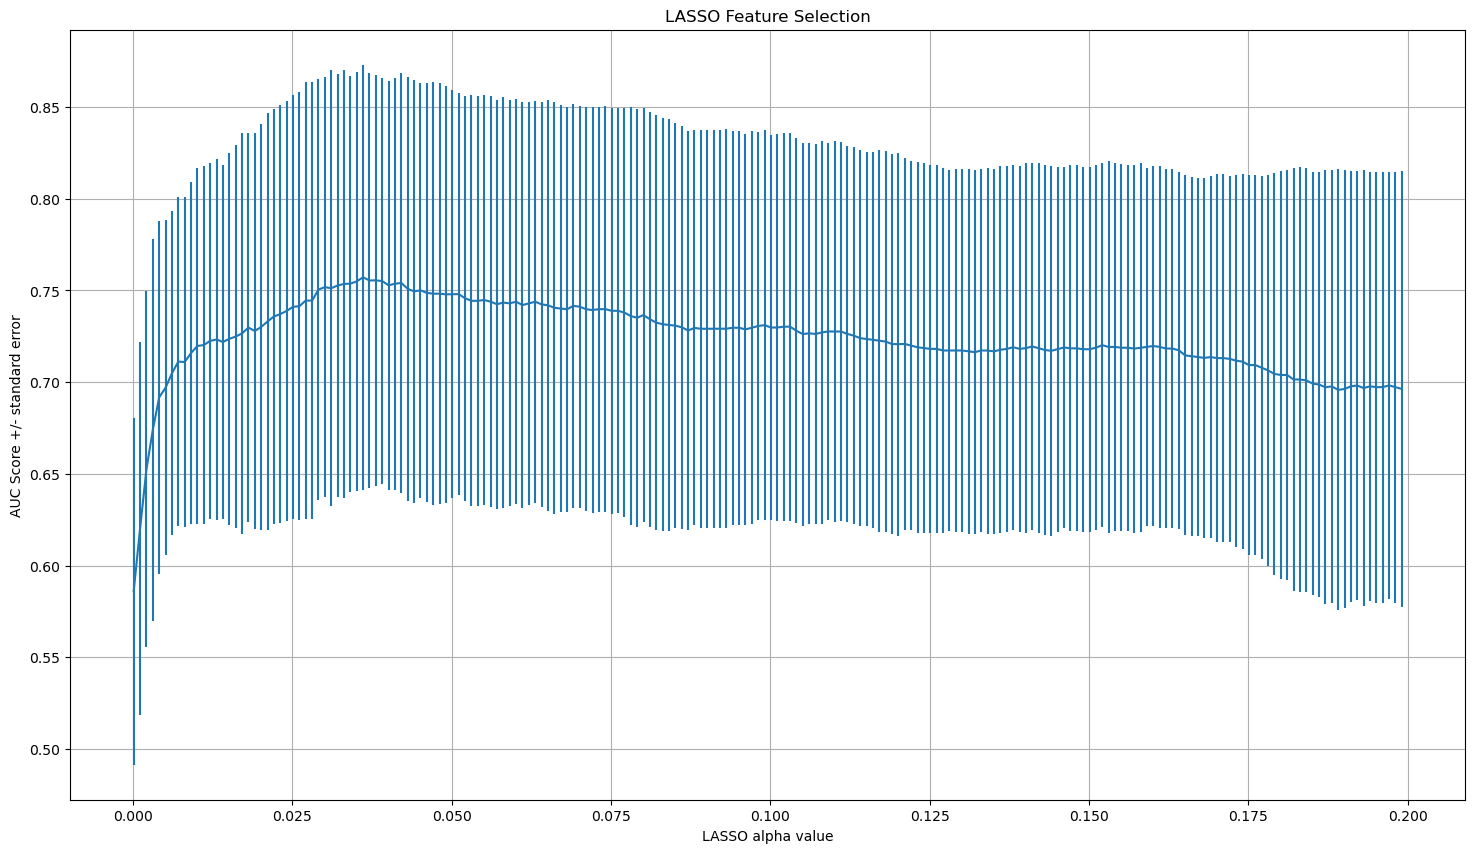

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
            
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)     
                                                
# X_train = np.concatenate([X_train, X_val], axis=0)
# y_train = np.concatenate([y_train, y_val], axis=0)

X_test = X_val
y_test = y_val

print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

alpha_range = np.arange(0.0001, 0.2, 0.001)
search = GridSearchCV(Lasso(),
                      {'alpha': alpha_range},
                      cv = 5, 
                      scoring="roc_auc",verbose=0
                      )

search.fit(X_train,y_train)
best_alpha = list(search.best_params_.values())[0]
print(f"Best Alpha: {best_alpha}")

sel_ = SelectFromModel(Lasso(alpha=best_alpha, random_state=42))
sel_.fit(X_train, y_train)
X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)

print(f"Num remaining feaures: {X_train.shape[1]}")

plt.figure(figsize=(18,10))
plt.errorbar(alpha_range, search.cv_results_["mean_test_score"], yerr=search.cv_results_["std_test_score"])
plt.xlabel("LASSO alpha value")
plt.ylabel("AUC Score +/- standard error")
plt.title("LASSO Feature Selection")
plt.grid()
plt.show()

### Feature Selection: PCA

Num remaining feaures: 79


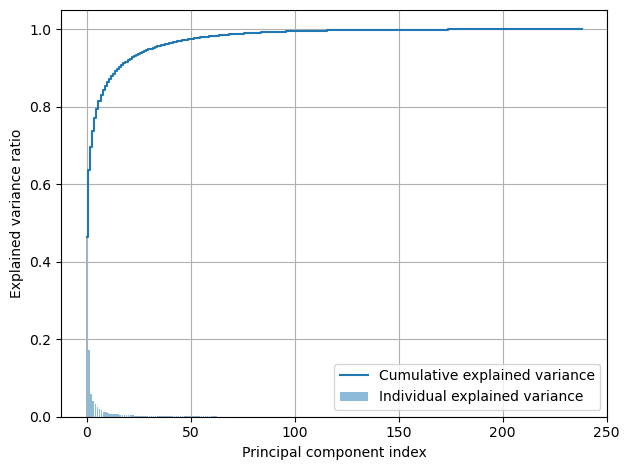

In [4]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# pca = PCA()
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# exp_var_pca = pca.explained_variance_ratio_
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# threshold = 0.99
# num_components_to_keep = None

# for idx, var_expl in enumerate(cum_sum_eigenvalues):
#     if var_expl > threshold:
#         num_components_to_keep = idx+1
#         break        
        
# print(f"Num remaining feaures: {num_components_to_keep}")

# X_train = X_train[:, :num_components_to_keep]
# X_test = X_test[:, :num_components_to_keep]

# plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='best')
# plt.tight_layout()
# plt.grid()
# plt.show()

### Random Oversampling

In [5]:
print(f"Before: {Counter(y_train)}")

oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(f"After:  {Counter(y_train)}")

Before: Counter({1: 112, 0: 103})
After:  Counter({0: 112, 1: 112})


### Support Vector Machine

In [6]:
svc = SVC(probability=True, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'poly', 'linear']
              }

svc = GridSearchCV(svc, param_grid, refit = True, verbose = 3, scoring='f1')
svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
y_prob_train = svc.predict_proba(X_train)
y_prob_test = svc.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print(f"Train ACC: {svc.score(X_train, y_train):.2f}")
print(f"Test  ACC: {svc.score(X_test, y_test):.2f}\n")

print(f"Train Balanced ACC: {balanced_accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test  Balanced ACC: {balanced_accuracy_score(y_test, y_pred_test):.2f}\n")

print(f"Train AUC: {roc_auc_score(y_train, y_prob_train[:, 1]):.2f}")
print(f"Test  AUC: {roc_auc_score(y_test, y_prob_test[:, 1]):.2f}\n")

print(f"Test  Sensitivity: {tp / (tp + fn):.2f}")
print(f"Test  Specificity: {tn / (tn + fp):.2f}\n")

print(f"Train F1-Score: {f1_score(y_train, y_pred_train, average='macro'):.2f}")
print(f"Test  F1-Score: {f1_score(y_test, y_pred_test, average='macro'):.2f}\n")

print(f"Train MCC: {matthews_corrcoef(y_train, y_pred_train):.2f}")
print(f"Test  MCC: {matthews_corrcoef(y_test, y_pred_test):.2f}\n")


print("Confusion Matrix")
print(cm)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV 1/5] END ....C=0.001, gamma=100, kernel=rbf;, score=0.657 total time=   0.0s
[CV 2/5] END ....C=0.001, gamma=100, kernel=rbf;, score=0.657 total time=   0.0s
[CV 3/5] END ....C=0.001, gamma=100, kernel=rbf;, score=0.000 total time=   0.0s
[CV 4/5] END ....C=0.001, gamma=100, kernel=rbf;, score=0.000 total time=   0.0s
[CV 5/5] END ....C=0.001, gamma=100, kernel=rbf;, score=0.745 total time=   0.0s
[CV 1/5] END ...C=0.001, gamma=100, kernel=poly;, score=0.652 total time=   0.0s
[CV 2/5] END ...C=0.001, gamma=100, kernel=poly;, score=0.694 total time=   0.0s
[CV 3/5] END ...C=0.001, gamma=100, kernel=poly;, score=0.680 total time=   0.0s
[CV 4/5] END ...C=0.001, gamma=100, kernel=poly;, score=0.809 total time=   0.0s
[CV 5/5] END ...C=0.001, gamma=100, kernel=poly;, score=0.711 total time=   0.0s
[CV 1/5] END .C=0.001, gamma=100, kernel=linear;, score=0.760 total time=   0.0s
[CV 2/5] END .C=0.001, gamma=100, kernel=linea

### Random Forest

In [7]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
y_prob_train = rfc.predict_proba(X_train)
y_prob_test = rfc.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print(f"Train ACC: {rfc.score(X_train, y_train):.2f}")
print(f"Test  ACC: {rfc.score(X_test, y_test):.2f}\n")

print(f"Train Balanced ACC: {balanced_accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test  Balanced ACC: {balanced_accuracy_score(y_test, y_pred_test):.2f}\n")

print(f"Train AUC: {roc_auc_score(y_train, y_prob_train[:, 1]):.2f}")
print(f"Test  AUC: {roc_auc_score(y_test, y_prob_test[:, 1]):.2f}\n")

print(f"Test  Sensitivity: {tp / (tp + fn):.2f}")
print(f"Test  Specificity: {tn / (tn + fp):.2f}\n")

print(f"Train F1-Score: {f1_score(y_train, y_pred_train, average='macro'):.2f}")
print(f"Test  F1-Score: {f1_score(y_test, y_pred_test, average='macro'):.2f}\n")

print(f"Train MCC: {matthews_corrcoef(y_train, y_pred_train):.2f}")
print(f"Test  MCC: {matthews_corrcoef(y_test, y_pred_test):.2f}\n")

print("Confusion Matrix")
print(cm)

Train ACC: 1.00
Test  ACC: 0.68

Train Balanced ACC: 1.00
Test  Balanced ACC: 0.68

Train AUC: 1.00
Test  AUC: 0.77

Test  Sensitivity: 0.61
Test  Specificity: 0.76

Train F1-Score: 1.00
Test  F1-Score: 0.68

Train MCC: 1.00
Test  MCC: 0.37

Confusion Matrix
[[26  8]
 [15 23]]
